# Introduction

In this lab, we will show how to use analytical derivatives to optimize coils.  First, we will introduce how coils are represented and parameterized.  Next, we will define quadratic penalty functions that depend on the geometry and position of the coils. We will also compute the analytical derivative of each penalty function with respect to the design parameters of the coils.  After constructing the objective function, we will compute its gradient analytically.  Finally, we will use a quasi-Newton method (the BFGS algorithm) to find optimal coils according to our objective function.

In [1]:
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


nphi = 100
phi = np.linspace(0,1, nphi+1)
phi = phi[0:-1]
nf = 2
coils_shape = (3,5)

## Coil optimization

We approximate stellarator coils as current-carrying filaments, where a coil $\Gamma$'s coordinates $(x,y,z)$ are written using a Fourier series, e.g. 

$$
x(\phi) = c_{0,x} + \sum_{k = 1}^{N_f} c_{k,x} \cos(2\pi k \phi) + s_{k,x} \sin(2\pi k \phi),
$$
where $\phi \in[0,1)$. Here, the coefficients $c_{k,x}$ and $s_{k,x}$ define the shape of the coil. The $y$ and $z$ components of the curves are similarly defined.

To illustrate this, let's plot some coils.  Here, $N_f = 2$ and we plot the curves describing the coils at `nphi = 100` points.

In [2]:
nphi = 100
phi = np.linspace(0,1, nphi+1)
phi = phi[0:-1]
nf = 2
coils_shape = (3,2*nf+1)


def gamma(coeffs):
    """
    Computes the (x,y,z) coordinates of the coils at nphi points along the curve.

    Inputs:
    - coeffs: A numpy array of shape (3, 2*nf+1) containing Fourier coefficients of a coil.
      The Fourier coefficients in coeffs are organized as follows
      coeffs = [ [c_{0,x}, c_{1,x}, s_{1,x}, c_{2,x}, s_{2,x}],
                 [c_{0,y}, c_{1,y}, s_{1,y}, c_{2,y}, s_{2,y}],
                 [c_{0,z}, c_{1,z}, s_{1,z}, c_{2,z}, s_{2,z}]]
    Returns:
    - gamma: A numpy array of shape (nphi,3) containing (x,y,z) coordinates of the coils at nphi points.
    """
    nphi = 100
    gamma = np.zeros((nphi, 3))
    for i in range(3):
        gamma[:, i] += coeffs[i][0]
        for j in range(1, 3):
            gamma[:, i] += coeffs[i][2*j-1] * np.sin(2*np.pi*j*phi)
            gamma[:, i] += coeffs[i][2*j]   * np.cos(2*np.pi*j*phi)
    
    return gamma 

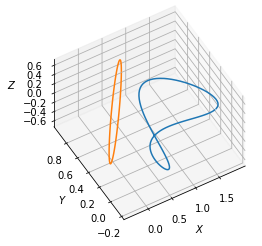

In [3]:
def plot_coils(coil_collection, azimuth=-120, elevation=50):
    
    """
    Plots the coils in coil_collection.

    Inputs:
    - coil_collection: list of numpy arrays that contain the Fourier coefficients of each coil that you wish to plot.
    - azimuth, elevation: camera view parameters
    """
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.figure()
    for coil in coil_collection:
        g = gamma(coil)
        ax = fig.gca(projection='3d')
        ax.plot(g[:,0],g[:,1],g[:,2])
    ax.set_xlabel('$X$', fontsize=10)
    ax.set_ylabel('$Y$', fontsize=10)
    ax.set_zlabel('$Z$', fontsize=10)
    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_proj_type('ortho')
    plt.show()
    
    
# Fourier harmonics organized in coil1 and coil2 as follows
# coil1 = [ [c_{0,x}, c_{1,x}, s_{1,x}, c_{2,x}, s_{2,x}],
#           [c_{0,y}, c_{1,y}, s_{1,y}, c_{2,y}, s_{2,y}],
#           [c_{0,z}, c_{1,z}, s_{1,z}, c_{2,z}, s_{2,z}]]

coil1 = np.array([[0.980785280403230,0,0.686549696282261,0.1,0.2],
                  [0.195090322016128,0,0.136563225411290,-0.1,-0.2],
                  [0,0.7,0,0,0]])
coil2 = np.array([[0.231469612302545,0,0.582028728611782,0,0],
                  [0.555570233019602, 0,0.388899163113722,0,0],
                  [0,0.7,0,0,0]])

# modify coil1 in the task below here:
# coil1 = np.array([[0,1,0,0,0],
#                   [0,0,1,0,0],
#                   [0,0,0,0,0]])

coil_collection = [coil1, coil2]
plot_coils(coil_collection)

# Task 1

Modify the Fourier coefficients in `coil1` above to obtain a flat coil centered at the origin with radius 1, contained in the $xy$ plane.

## Let's compute the length of each coil

The length of a coil is given by
$$
L = \int^{1}_{0} ||\Gamma'(\phi)||_2 d\phi,
$$
where $||\Gamma'(\phi)||_2$ is the norm of the coil tangent vector.
We can compute the length by discretizing the above using the trapezoidal rule.  
The length becomes
$$
L = \frac{1}{N_{\phi}} \sum^{N_{\phi}-1}_{k = 0}||\Gamma'(\phi_k)||_2,
$$
where $N_{\phi}$ is the number of quadrature points and $\phi_k = k/N_{\phi}$.

In [4]:
def dgamma_by_dphi(coeffs):
    """
    computes the derivative of the (x,y,z) points of the coil 
    with respect to \phi, i.e., this function computes the coil tangent at each quadature point
    along the coil.
    

    Inputs:
    - coeffs: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of a coil.
    
    Outputs:
    - dgamma_by_dphi: a numpy array of size (nphi, 1, 3) which contains the three components of the coil
                      tangent at each of the nphi quadrature points.
    """
    dgamma_by_dphi = np.zeros((nphi, 1, 3))
    for i in range(3):
        for j in range(1, nf+1):
            dgamma_by_dphi[:, 0, i] += +coeffs[i][2*j-1] * 2*np.pi*j*np.cos(2*np.pi*j*phi)
            dgamma_by_dphi[:, 0, i] += -coeffs[i][2*j] * 2*np.pi*j*np.sin(2*np.pi*j*phi)

    return dgamma_by_dphi

def dgamma_by_dcoeff():
    """
    computes the derivative of the (x,y,z) points of the coil 
    with respect to the Fourier coefficients. 
    

    Inputs:
    - coeffs: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of a coil.
    
    Outputs:
    - dgamma_by_dcoeff: a numpy array of size (nphi, 1, 3) which contains the derivative 
                        of the (x,y,z) coordinates of the curve with respect to the Fourier coefficients.
    """
    dgamma_by_dcoeff = np.zeros((nphi, 3*(2*nf+1), 3))
    for i in range(3):
        dgamma_by_dcoeff[:, i*(2*nf+1), i] = 1
        for j in range(1, nf+1):
            dgamma_by_dcoeff[:, i*(2*nf+1) + 2*j-1, i] = np.sin(2*np.pi*j*phi)
            dgamma_by_dcoeff[:, i*(2*nf+1) + 2*j  , i] = np.cos(2*np.pi*j*phi)
    return dgamma_by_dcoeff


def d2gamma_by_dphidcoeff():
    """
    computes the derivative of the (x,y,z) points of the coil 
    with respect to phi and the Fourier coefficients. That is, this returns the derivatives of
    the coil tangents with respect to the Fourier coefficients.
    
    Outputs:
    - dgamma_by_dcoeff: a numpy array of size (nphi, 1, 3*(2*nf+1), 3) which contains the derivative 
                        the derivatives of the coil tangents with respect to the Fourier coefficients.
    """
    d2gamma_by_dphidcoeff = np.zeros((nphi, 1, 3*(2*nf+1), 3))
    for i in range(3):
        for j in range(1, nf+1):
            d2gamma_by_dphidcoeff[:, 0, i*(2*nf+1) + 2*j-1, i] = +2*np.pi*j*np.cos(2*np.pi*j*phi)
            d2gamma_by_dphidcoeff[:, 0, i*(2*nf+1) + 2*j  , i] = -2*np.pi*j*np.sin(2*np.pi*j*phi)
    return d2gamma_by_dphidcoeff
    
def L(coeffs):
    """
    computes the length of a coil.

    Inputs:
    - coeffs: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of a coil.
    
    Outputs:
    - L: the length of the coil.
    """
    dgamma = dgamma_by_dphi(coeffs)
    inc_arc_length = np.sqrt(dgamma[:,0,0]**2+dgamma[:,0,1]**2+dgamma[:,0,2]**2)
    return (1./nphi)*np.sum(inc_arc_length,0)

def dL_by_dcoefficients(coeffs):
    """
    computes the derivative of the length of a coil with respect to the Fourier coefficients of the coil.

    Inputs:
    - coeffs: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of a coil.
    
    Outputs:
    - res: a numpy array with shape (3*(2*nf+1)) the derivatives of length of the coil 
           with respect to the Fourier coefficients.
    """
    
    dgamma =  dgamma_by_dphi(coeffs)
    dgamma = dgamma[:,0,:]
    d2gamma = d2gamma_by_dphidcoeff()
    d2gamma = d2gamma[:, 0, :, :]
    
    
    num_coeff = d2gamma.shape[1]
    res = np.zeros((num_coeff, ))
    arc_length = np.linalg.norm(dgamma, axis=1)
    for i in range(num_coeff):
        res[i] = np.mean((1/arc_length) * np.sum(d2gamma[:, i, :] * dgamma, axis=1))
    return res

In [5]:
coil1 = np.array([[0.980785280403230,0,0.686549696282261,0.1,0.2],
                  [0.195090322016128,0,0.136563225411290,-0.1,-0.2],
                  [0,0.7,0,0,0]])
coil2 = np.array([[0.231469612302545,0,0.582028728611782,0,0],
                  [0.555570233019602, 0,0.388899163113722,0,0],
                  [0,0.7,0,0,0]])
print(L(coil1))

5.116640014479016


## Task 3

Verify that the length of the coil that you found in Task 1 is indeed computed to be $2\pi$.

## Coil-to-coil distance

We do not want the coils to be too close to one another, so let's design a penalization term that prevents this. Note that imposing a minimal coil distance is an inequality constraint, for which we use a quadratic penalization.

$$
R(\mathbf{c}_1, \mathbf{c}_2) = \int_{0}^{1}\int_{0}^{1}\max(d-||\Gamma_1(\theta_1) - \Gamma_2(\theta_2)||_2,0)^2 ~d\theta_1 d \theta_2
$$
where $d > 0$. 

This penalizes coil-to-coil distance that are not greater than $d$, since the integrand is nonzero when $d> ||\Gamma_1(\theta_1) - \Gamma_2(\theta_2)||_2$.

Again, this term can be discretized using the trapezoidal rule, and becomes
$$
R(\mathbf{c}_1, \mathbf{c}_2) = \frac{1}{N^2_{\phi}}\sum^{N_{\phi}-1}_{i = 0}\sum^{N_{\phi}-1}_{j = 0} \max(d-||\Gamma_1(\theta_i) - \Gamma_2(\theta_j)||_2,0)^2
$$

In [6]:
def R(coil1, coil2, d):
    """
    computes the minimum distance penalty function.

    Inputs:
    - coil1: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of the first coil.
    - coil2: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of the second coil.
    - d: coefficient that describes how far away we would like the coils to be from one another.  If d is large, 
         this penalty term will be large as well.
    Outputs:
    - res: minimum distance penalty function.
    """
    res = 0
    gamma1 = gamma(coil1)
    gamma2 = gamma(coil2)
    dists = np.sqrt(np.sum((gamma1[:, None, :] - gamma2[None, :, :])**2, axis=2))
    res += np.sum(np.maximum(d-dists, 0)**2)/(gamma1.shape[0]*gamma2.shape[0])
    return res

def dR_by_dcoefficients(coil1,coil2,d):
        """
        computes the derivative of the minimum distance penalty function with respect to the coil coefficients.

        Inputs:
        - coil1: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of the first coil.
        - coil2: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of the second coil.
        - d: coefficient that describes how far away we would like the coils to be from one another.  If d is large, 
             this penalty term will be large as well.
        Outputs:
        - res1: derivative of the minimum distance penalty function with respect to the first coil.
        - res2: derivative of the minimum distance penalty function with respect to the second coil.
        """

        gamma1 = gamma(coil1)
        dgamma1 = dgamma_by_dcoeff()
        numcoeff1 = dgamma1.shape[1]
        res1 = np.zeros((numcoeff1, ))

        gamma2 = gamma(coil2)
        dgamma2 = dgamma_by_dcoeff()
        numcoeff2 = dgamma2.shape[1]
        diffs = gamma1[:, None, :] - gamma2[None, :, :]
        res2 = np.zeros((numcoeff2, ))
        
        dists = np.sqrt(np.sum(diffs**2, axis=2))
        for ii in range(numcoeff1):
            res1[ii] += np.sum(-2 * np.maximum(d - dists, 0) * np.sum(dgamma1[:, ii, :][:, None, :] * diffs, axis=2)/dists)/(gamma1.shape[0]*gamma2.shape[0])
        for jj in range(numcoeff2):
            res2[jj] -= np.sum(-2 * np.maximum(d - dists, 0) * np.sum(dgamma2[:, jj, :][None, :, :] * diffs, axis=2)/dists)/(gamma1.shape[0]*gamma2.shape[0])
        return res1,res2

In [9]:
d = 0.5
coil1 = np.array([[0.980785280403230,0,0.686549696282261,0.1,0.2],
                  [0.195090322016128,0,0.136563225411290,-0.1,-0.2],
                  [0,0.7,0,0,0]])
coil2 = np.array([[0.231469612302545,0,0.582028728611782,0,0],
                  [0.555570233019602, 0,0.388899163113722,0,0],
                  [0,0.7,0,0,0]])
print(R(coil1,coil2, d))

0.00022184300441445778


## Optimization of coils

Now that we have two scalar quantities that can be computed from our coils, let's solve a contrained optimization problem. Note that we have several ways to formulate that, we can either consider the coil distance or the coil length as constraint or its quadratic penalization as objective. Either way, there are weight parameters $\mu$ that balance which objective term is more important to us.

We hope to find two coils that are not too close to one another, that have a prescribed length $L_0$.  That is, we hope to solve

\begin{align}
\min_{\mathbf{c}_1, \mathbf{c}_2} ~&R(\mathbf{c}_1, \mathbf{c}_2) \\
\text{subject to } &L_1(\mathbf{c}_1) - L_0 = 0 \\
&L_2(\mathbf{c}_2) - L_0 = 0,
\end{align}
where $\mathbf{c}_1$ and $\mathbf{c}_2$ are the design parameters of each coil, i.e., the Fourier coefficients.

Let's do that by introducing a quadratic penalty term for each equality constraint

\begin{align}
\min_{\mathbf{c}_1, \mathbf{c}_2} &~R(\mathbf{c}_1, \mathbf{c}_2) + \frac{\mu_1 }{2}(L_1(\mathbf{c}_1) - L_0)^2+ \frac{\mu_2 }{2}(L_1(\mathbf{c}_2) - L_0)^2.
\end{align}

Thus, we would like to solve the above unconstrained optimization problem. Moreover, the parameters $\mu_1$ and $\mu_2$ describe the trade-off between how important the lengths terms are compared to the coil distance term. Making them very large means we want the achieve the target coil length almost exactly, while keeping them smaller means that enforcing coil distance is more important.
The functions below compute the objective function and its gradient.


In [10]:
def pack_dofs(coil1,coil2):
    """
    packs the degrees of freedom (dofs) of coil1 and coil2 into a single linear array.

    Inputs:
    - coil1: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of the first coil.
    - coil2: a numpy array of shape (3, 2*nf+1) containing Fourier coefficients of the second coil.
    Outputs:
    - a flattened array of both coil dofs with shape (2*3*(2*nf+1)).
    """
    return np.hstack((coil1.flatten(), coil2.flatten()))
def unpack_dofs(x):
    """
    unpacks the degrees of freedom (dofs) of a linearized array into
    two matrices containing the Fourier coefficients of each coil.

    Inputs:
    - x: a flattened array of both coil dofs.
    Outputs:
    - two numpy arrays with shape (3,2*nf+1) containing the Fourier coefficients of each coil.
    """
    coil1 = np.reshape(x[0:coils_shape[0]*coils_shape[1]], coils_shape)
    coil2 = np.reshape(x[coils_shape[0]*coils_shape[1]::], coils_shape)
                       
    return [coil1,coil2]

def J(x):
    """
    computes the objective function with minimum distance penalty, and quadratric penalty terms corresponding 
    to the two length equality constraints.

    Inputs:
    - x: a flattened array of both coil dofs.
    Outputs:
    - J(x)
    """
    [coil1, coil2] = unpack_dofs(x)
    return R(coil1,coil2,d) + 0.5 * mu1 * (L(coil1) - L0)**2 + 0.5 * mu2 * (L(coil2) - L0)**2

def dJ(x):
    """
    computes the gradient of the objective function J(x).

    Inputs:
    - x: a flattened array of both coil dofs.
    Outputs:
    - dJ(x): gradient of J(x) with respect to x.
    """

    [coil1, coil2] = unpack_dofs(x)
    L1 = L(coil1)
    L2 = L(coil2)
    
    dL_by_dcoeff1 = dL_by_dcoefficients(coil1)
    dL_by_dcoeff2 = dL_by_dcoefficients(coil2)  
    dR_by_dcoeff1,dR_by_dcoeff2 = dR_by_dcoefficients(coil1,coil2,d)
    
    dJ_dcoil1 = dR_by_dcoeff1 + mu1 * (L1-L0)* dL_by_dcoeff1
    dJ_dcoil2 = dR_by_dcoeff2 + mu2 * (L2-L0)* dL_by_dcoeff2
    
    return np.hstack((dJ_dcoil1.flatten(), dJ_dcoil2.flatten()))

# Evaluating the objective and its gradient

Below is some code that will allow you to set the weights of the quadratic penalty terms, $d$.  Next it linearizes the degrees of freedom associated to the coils into the array `x`.  Finally, it allows you to evaluate the objective and its gradient.

## Task 4
Try various values of $d$.  When is the norm of the gradient 0?

In [13]:
mu1 = 1
mu2 = 1
d = 0.2
L0 = 4.398229715025718


coil1 = np.array([[0.980785280403230,0,0.686549696282261,0,0],
                  [0.195090322016128,0,0.136563225411290,0,0],
                  [0,0.7,0,0,0]])
coil2 = np.array([[0.831469612302545,0,0.582028728611782,0,0],
                  [0.555570233019602, 0,0.388899163113722,0,0],
                  [0,0.7,0,0,0]])
x = pack_dofs(coil1,coil2)
print(J(x), np.linalg.norm(dJ(x)))

3.139333036724862e-05 0.0023958448681581255


# Taylor Test

Verify your implementation of the objective function J and its gradient dJ by doing a Taylor test.  In the code below, we are computing the directional derivative of $J$ in a random direction $h$ using a finite difference stencil of various orders of accuracy.  Then, we are comparing the finite difference direction derivative, with the analytical directional derivative computed by the code. This is a standard way of verifying that the gradient has been correctly implemented.

## Task 5

Interpret the error versus finite difference stepsize plot below.

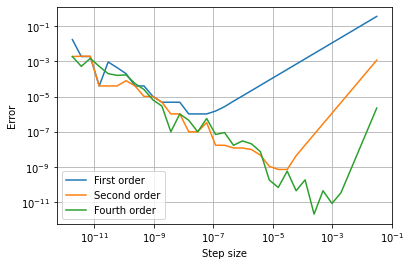

In [17]:
mu1 = 2.1123
mu2 = 0.523
d = 12.124
L0 = 1.124354

coil1 = np.array([[0.980785280403230,0,0.686549696282261,0.1,0.2],
                  [0.195090322016128,0,0.136563225411290,-0.1,-0.2],
                  [0,0.7,0,0,0]])
coil2 = np.array([[0.231469612302545,0,0.582028728611782,0,0],
                  [0.555570233019602, 0,0.388899163113722,0,0],
                  [0,0.7,0,0,0]])
np.random.seed(0)
x = pack_dofs(coil1,coil2)
h = np.random.rand(x.shape[0])
h = h/np.linalg.norm(h)

error = np.zeros((4, 35))
eps_list = 0.5**np.array(range(5,40))
for i,order in enumerate([1, 2, 4]):
    if order == 1: # first order forward difference.
        shifts = [0, 1]
        weights = [-1, 1]
    elif order == 2: # second order central difference.
        shifts = [-1, 1]
        weights = [-0.5, 0.5]
    elif order == 4: # fourth order central difference.
        shifts = [-2, -1, 1, 2]
        weights = [1/12, -2/3, 2/3, -1/12]

    j = J(x)
    dj = dJ(x)
    dj_exact = np.dot(h,dj)
    
    dj_fd = 0
    for ii in range(5, 40):
        eps = 0.5**ii
        
        dj_fd = 0
        for s,w in zip(shifts,weights):
            dj_fd = dj_fd + w*J(x+s*eps*h)
        dj_fd = dj_fd / eps
        error[i, ii-5] = np.abs( dj_fd - dj_exact )

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
for ii in range(3):
    plt.loglog(eps_list, error[ii,:])
plt.grid()
plt.xlabel('Step size')
plt.ylabel('Error')
plt.legend(['First order', 'Second order', 'Fourth order'])

## Coil optimization

Now that we've verified implementation, we can optimize some coils.  In this example, we are going attempt to optimize the objective function defined above.  That is, we will try and push the coils away from one another, without modifying their lengths.

The view below is directly above the coils.  Feel free to rotate the plot in order to view the initially flat coils from different angles.

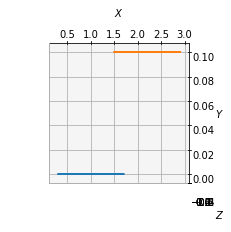

In [18]:
coil1 = np.array([[1.,0,0.7,0,0],
                  [0,0,0.0,0,0],
                  [0,0.7,0,0,0]])
coil2 = np.array([[2.2,0,0.7,0,0],
                  [0.1,0,0.0,0,0],
                  [0,0.7,0,0,0]])

x0 = pack_dofs(coil1,coil2)
plot_coils([coil1,coil2], -90,90)


# Task 6

Trivially, one could simply shift the blue coil down, or the orange coil up such that the minimum distance penalty term becomes zero.  Do this in the code below and verify that for coils far enough away from one another, the objective function becomes zero.  Recall that $J$ computes
$$
\begin{align}
R(\mathbf{c}_1, \mathbf{c}_2) + \frac{\mu_1 }{2}(L_1(\mathbf{c}_1) - L_0)^2+ \frac{\mu_2 }{2}(L_1(\mathbf{c}_2) - L_0)^2.
\end{align}
$$

0.00337473729253409


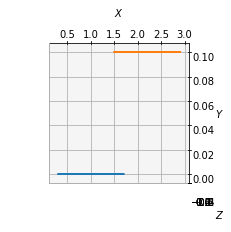

In [19]:
mu1 = 1
mu2 = 1
d = 0.5
L0 = 4.398229715025718


coil1 = np.array([[1.,0,0.7,0,0],
                  [0,0,0.0,0,0],
                  [0,0.7,0,0,0]])
coil2 = np.array([[2.2,0,0.7,0,0],
                  [0.1,0,0.0,0,0],
                  [0,0.7,0,0,0]])
x = pack_dofs(coil1,coil2)
print(J(x))
plot_coils([coil1,coil2], -90,90)

# A more interesting solution

In order to find a more interesting solution, we need to add more constraints to the coils.

One set of additional constraints would be to fix the $x$, $z$ Fourier coefficients of the coils along with the mean y values.  That is, we only allow
$$
c_{1,y}, s_{1,y}, c_{2,y}, s_{2,y}
$$
of each coil to vary.

## Task 7
Vary $d$ and see how that affects the coils that minimizes the objective function.

Note: we would not do this in practice, this is just to illustrate that our coils have too much freedom.  The coils of that minimize the objective function are plotted below, viewed from above.  Feel free to view them at different angles.


0.00337473729253409 0.01750695524117225
0.0014901991534205907 8.147175538656039e-11


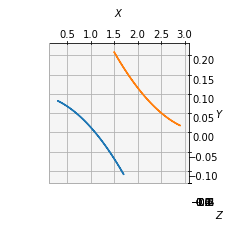

In [20]:
from scipy.optimize import minimize

# Fourier harmonics organized as follows
# coil1 = [ [0 c_{0,x}, 1 c_{1,x}, 2 s_{1,x}, 3 c_{2,x}, 4 s_{2,x}],
#           [5 c_{0,y}, 6 c_{1,y}, 7 s_{1,y}, 8 c_{2,y}, 9 s_{2,y}],
#           [10 c_{0,z}, 11 c_{1,z}, 12 s_{1,z}, 13 c_{2,z}, 14 s_{2,z}]]



# indices of the Fourier coefficients of x, z coordinates and mean y coefficient of FIRST coil.
idx1 = np.array([0,1,2,3,4,
                 5,
                 10,11,12,13,14])
# indices of the Fourier coefficients of x, z coordinates and mean y coefficient of SECOND coil.
idx2 = np.array([0,1,2,3,4,
                 5,
                 10,11,12,13,14])+15


def scipy_fun(x):
    res = J(x)
    dres = dJ(x)
    
    # fix the derivative of the Fourier coefficients with indices idx1 and idx2 to 0.
    dres[idx1] = 0
    dres[idx2] = 0
    
    return res, dres

mu1 = 1
mu2 = 1
d = 0.5
L0 = 0.7*2*np.pi

coil1 = np.array([[1.,0,0.7,0,0],
                  [0,0,0.0,0,0],
                  [0,0.7,0,0,0]])
c2 = np.array([[2.2,0,0.7,0,0],
                  [0.1,0,0.0,0,0],
                  [0,0.7,0,0,0]])


x0 = pack_dofs(coil1,c2)


j,dj = scipy_fun(x)
print(j,np.linalg.norm(dj))
res = minimize(scipy_fun, x0, jac=True, method='bfgs', tol=1e-10,options={"maxiter": 200})

j,dj = scipy_fun(res.x)
print(j,np.linalg.norm(dj))


out_c1,out_c2 = unpack_dofs(res.x)
plot_coils([out_c1,out_c2], -90,90)
# print(res)
